<a href="https://colab.research.google.com/github/suhkisoo/course-v3/blob/master/Copy_of_Copy_of_Copy_of_QuadCurveGanFinalExam_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data & AI Final Exam. The final exam is focused on Generative Adversarial Networks (GANs).
https://wiki.pathmind.com/generative-adversarial-network-gan

 They are deep neural net architectures composed of a pair of competing neural networks: a generator and a discriminator. This model is trained by alternately optimizing two objective functions so that the generator G learns to produce samples resembling real images, and the discriminator D learns to better discriminate between real and fake data.

GAN is important because it has a huge potential. So, we want to understand its principle well enough. 

Please read the following gan code and comments carefully and write down answers to the questions in this notebook. Submit the notebook to your github repo. This code is executable on colab as it is. You had better answer the questions starting from Question 1. The order of questions is not sequential from top to bottom. Notice that answers to many questions can be obtained when you read the code and the comments carefully. The answer to a question may be found in another question itself. But all these will be seen only to those who understand what is going on. ** Please do not copy words of comments when you write down your answers. Write your own words** 

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot


# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    # class Sequential(Model) = Linear stack of layers
    # The `Model` class adds training & evaluation routines to a `Network`.
    # class Model(Network): add(self, layer): 	Adds a layer instance on top of the layer stack.

    model = Sequential()  # model is an object of class Sequential
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    # n_inputs = 2; n_output=25:  The Input vector is a 2D point (x,y)
    model.add(Dense(1, activation='sigmoid'))
    # n_input = 25 = n_output of the previous layer; n_output =1 ( The value of the discriminator output is probability between  o and 1
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.loss = loss ="binary_crossentropy": Using the binary cross entropy function as the loss
    # function means that it tries to minimize the difference (loss) between the predicted probability of the net
    # for the input to belong to one of the two categories and the labeled probability which is either 1 (real)or 0 (fake).
    # It tries to minimize this difference (loss) for all inputs (whose number is 128 in our example); it means that
    # it tries ot minimize the average difference (loss) of the all inputs. The basic idea is the same with the mean square error
    # loss for regression problem. The difference is the "value" used to compute the loss probability rather than ordinary values.

    return model  # model is a reference  to the current instance of the class


# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):  # latent_dim =5
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform',
                    input_dim=latent_dim))  # n_input=5 = latent_dim; n_output=15
    model.add(Dense(n_outputs, activation='linear'))  # n_input = 15 = n_output of the previous layer; n_output = 2
    # The dimension of the output of the geneator is 2, 
    # because it generates a 2D point (x,y) which is supposed to lie on
    # the quadratic curve y = x^2;
    return model


# define the combined generator and discriminator model for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False  # discriminator is set as not trainable when it is part of the composite model
    # But it is trainable when it is used alone
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # model.loss = loss ="binary_crossentropy"
    return model

#  Making the discriminator not trainable is a clever trick in the Keras API. The trainable
#  property impacts the model when it is compiled. The discriminator model was compiled with
#  trainable layers, therefore the model weights in those layers will be updated when the standalone
#  model is updated via calls to train on batch().

# generate n real samples with class labels "ones" for training the discriminator
def generate_real_samples(n): # n = 128/2
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))  # X =  hstack( [1,2], [3,4] ) ==>[ [1,3],[2,4] ] : 128 points
    # generate class labels
    y = ones((n, 1))  # y = 128/2 labels
    return X, y  # # A pair of 128/2 real samples and their 128 labels


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)  # [01, 02, 0.9,...., 0,1]
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)  # 128 * 5 matrix
    return x_input


# use the generator to generate n fake examples, with class labels "zero", for training the discriminator
def generate_fake_samples(generator, latent_dim, n): # n = 128/2
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)  # 128/2  x 5: 128/2 samples of 5 random numbers
    # predict outputs
    X = generator.predict(x_input)  # X = 128/2 generator outputs for 128/2 samples of 5 numbers
    # create class labels
    y = zeros((n, 1))  # y = 128/2  labels
    return X, y  # A pair of 128/2 fake samples and their 128/2 labels


# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)  # (x_real, y_real):  A pair of 128 real samples and their 128 labels
    # evaluate discriminator on real examples, that is, compute the accuracy function of the net
    # The output of the discriminator net is the probability that an input has with respect to being fake or real.
    # If the probability is near 1, it is likely that the input is real, and vice versa.
    # If the proability is 0.5, it means that the discriminator cannot tell if the input is real or fake.
    # This state is the best that the generator tries to achieve; the generator does not want to be too much 
    # similar to real data. It wants to produce novel data, but it does not want to be refused by the 
    # discriminator or critic. 
     
    _, acc_real = discriminator.evaluate(x_real, y_real,
                                         verbose=0)  # acc_real = THe accuray of the discriminator net that tells "real" for real samples (inputs)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim,
                                           n)  # (x_fake, y_fake):  # A pair of 128 fake samples and their 128 labels
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake,
                                         verbose=0)  # acc_fake = The accuray of the discriminator net that tells "fake" for fake samples (inputs)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)  # print both acc_real and acc_fake for the current epoch.
    # scatter plot real and fake data points: 
    # x_real[i,0] is the x coord of ith real point and x_real[i,1] is the y coord of ith real point

    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch + 1)
    pyplot.savefig(filename)
    pyplot.close()


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)

    # loop over epochs: In the case of typical supervised learning, one epoch refers to one scan over the entire dataset
    # in the process of training the network.
    # In this gan example, one epoch refers to one scan over a single mini-batch.
    # This is because the real data is prepared not in the form of entire dataset in the beginning,
    # but is computed in the form of mini-batch by "generate_real_samples" function at each update of the discriminator.
    #
    for i in range(n_epochs):
        # 1) Train the discriminator to discriminate between real-data and fake-data

        # 1.1)  prepare real samples (real mini-batch): note that in this example, the discriminator will see
        #  10000 * 128/2 real data ( 2D points from the quadratic curve y = x^2) in total throughout all the epochs.
        # It means also that the discriminator encounters the same number of fake 2D points throughout all the epochs.
        # and is trained to tell "fake" to them. The fake data used by the discriminator become smarter as the epoch
        # progresses.

        x_real, y_real = generate_real_samples(half_batch)

# Q3. In each epoch,  x_real and y_real are created.
#  Q3.1) What are these? 
# - x_real is point in (-0.5,0.5) and it is on the function y=x^2. y_real is label value 1 that means the x_real, point is real.
#  Q3.2) In this code, how many real samples are created in each epoch? 
# - In this example, 64. Half of the n_batch is created. 


        # prepare fake examples (fake mini_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

# Q4. In each epoch, x_fake and y_fake are generated. They are generated by using "g_model".
# Q4.1) What are they? 
# - x_fake is fake point that generator made. y_fake is label value 0 that means the x_fake is fake.
# Q4.2) How many "faked" data are generated? 
# - In this example, 64. Half of the n_batch is created. 
# Q4.3) Initially the generator "g_model" would be very poor at generating
#        reasonable data. What is the use to these poor data?
# - These data train discrimnator with the characteristics of fake data. Then discriminatr can know differences between real and fake data.

        # 1.2)  update discriminator
        # "Runs a single gradient update on a single mini-batch of data":
        d_model.train_on_batch(x_real, y_real)  # train the discriminator using the real mini-batch

# Q5. The discriminator "d_model" is trained by using x_real, y_real. 
#  Q5.1) What value does "y_real" have?
# - It has value 1 that means real.  
#  Q5.2) What is the goal of this training?
# That is, what is the network trained to achieve by using these data?
# - Develop discriminator's real point judgment skills.

        d_model.train_on_batch(x_fake,y_fake)  # train the discriminator using the fake mini-batch.

# Q6. The discriminator "d_model" is also trained by using x_fake, y_fake.
# Q6.1) What value does "y_fake" have?
# - It has value 0 that means fake. 
# Q6.2) What is the goal of this training? That is, what is the network trained to do by using these data?
# - Develop discriminator's fake point judgment skills.
# Q7. Why do you train "d_model" on both x_real, y_real and x_fake, y_fake?
# If you only educate with real or fake data, you can't tell the difference between the two, so you should educate both so that discriminator can recognize the difference.


# Q8. Now in the current epoch, after the discriminator is trained both on real data and fake data, the
#     generator is trained as follows:

# Q8.1) What is the goal of the training of the generator? That is, what is the net trained to achieve?
# - The goal is to train generator to create data that is indistinguishable from the real one.

        # 2) Train the generator net
        # 2.1) prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim,
                                       n_batch)  # x_gan = 128 x 5 matrix; This means 128 samples of 5 random numbers
        # 2.2) create labels that the discriminator should produce for the fake sample output of the generator
        # Note that while the generator is updated in order to "fool" the discriminator, the discriminator is fixed.
        y_gan = ones((n_batch, 1))  # 128 1's

        # 2.3) update the generator  so that the loss of the fixed discriminator is minimized.
        gan_model.train_on_batch(x_gan, y_gan)   # x_gan= input to the generator = 128 samples of 5 random vectors,
                                                 # y_gan = target label = 128 labels (all 1's) for the discriminator

# Q8.2)  What is the size of x_gan and y_gan?
# - There are 128 x_gan and y_gan. x_gan is 128 point samples of 5 random vectors and y_gan is 128 value 1. 
# Q8.3) Although "gan_model.train_on_batch()" may imply that gan_model is trained, 
#       in fact, x_gan and y_gan are  used to train the generator part of gan_model.
#      But then why is gan_model referred to (which contains the discriminator net) to train the generator?
# - Since the goal of the generator is to deceive the discriminator, the decision result of the discriminator is necessary for the training of the generator.

# Q8.4) Is the discriminator in gan_model updated (trained) when the generator part is updated (trained)?
# - NO.
#        Explain why.
# - This is because the results produced by the generator have value 1 even though they are fake, so training the discriminator through them will reduce the discriminator's performance.


        # NOTE: gan_model.train_on_batch(x_gan, y_gan) tries to train  the generator so that the discriminator tells "real"
        # for EVERY (fake) output generated by the generator. Note that this goal is a bit indirect in the sense that
        # the generator does not attempt to optimize its output directly but it tries to optimize the
        # the output of the discriminator. But it is not uncommon. For example, consider the effort of parents
        # with respect to their children.

        # evaluate the model every n_eval epochs
        if (i + 1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            
#Q9. Q9.1) What does the above statement do?
# - It evaluates the discriminator and plot real and fake points.
#    Q9.2) Read the result of the above statement. Explain what happens as the epoch progresses.
# - In general, later the more similar the accuracy of the two. The decimator training increases the true accuracy and also increases the fake accuracy.
#    Q9.3) Do you think that the gan would happy if the real-accuray and the fake-accuracy are similar?
# - Yes.
#          If so, explain why.
# -  Because the discriminator's inability to distinguish the real from the fake means that the generator's performance has increased.
#    Q9.4) In the content folder on the left column, you can see image files that show the progress of
#          the generator; It describes the report of the performance in a different way. 
#          Everything may look as you expected or not. 

#          Copy the images showing unexpected results to the notebook and explain
#          what are the unexpected results. You can also refer to the report of the performance 
#          in your  explantion.  If no picture shows unexpected results, then explain why you think so,
#          referring the pictures and the report of the performance.
# Answer is in below.



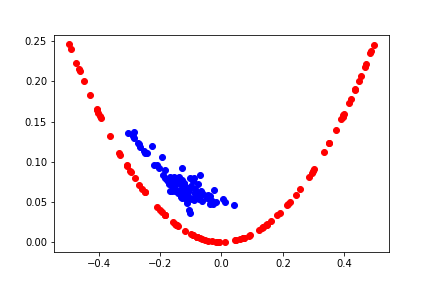
It was crowded to one side, so the results were not done properly, which can be checked in performance.

Questions: In the code above, functions need to build and train the gan are defined.
In the code below, these functions are used to actually train the gan. This gan
is a network that generates points on quadratic curve y = x^2, 
                                              where x is in [-0.5,0.5]. 
The gan does not know that these points come form the quadratic curve.
This network can be constructed and trained by means of supervised learning 
technique. That would be better for this problem. But in order to understand what
is going on in gan, we will use this simple toy problem. 

Q1. Read function "define_generator". 
This function does not return some numbers, but some
abstract entity.

Q1.1) What kind of entity is it? 
It is something that transforms an input to an output. 

Q1.2) What is its input? 
Q1.3) What is its output?
Q1.4) When the generator is first created, what values 
would its parameters/weights have? The values of the parameters will be updated as
the training is going on. But what values would they have initially? 

Q2. Read function "define_discriminator". This function defines a discriminator 
network which classifies its input as "fake" (0) or as "real" (1).
Q2.1) What is the dimension of the input vector? 
Q2.2) Why does the dimension of the input vector have that particular number?
Q2.3) What is the dimension of the output?
Q2.4) Why is it so?

In [ ]:
#Q1.1)It's sequential class model. It is stack of layers that have input and output.  
#Q1.2)Input is latnet_dim, 5.
#Q1.3)Output is (x,y) that supposed to be at y=x^2 function. 
#Q1.4)It is samples from a uniform distribution within [-limit, limit] , where limit = sqrt(6 / fan_in).
#Q2.1)It's two dimension. 
#Q2.2)Because it is ouput of generator. And the output of generator is 2D point (x,y).
#Q2.3)It's one dimension. 
#Q2.4)Because output is probability between o and 1. It's probability of point (x,y).

In [ ]:
# size of the latent space (the size of a random input vector to the generator)
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
#  discriminator is a reference  to the instance of the Sequential class
#  discriminator defines the loss function and the optimization method

# create the generator
generator = define_generator(latent_dim)  # generator does not define  the loss function and the optimization method
# create the gan
gan_model = define_gan(generator, discriminator)
# train model

# Q3: The funtion "train" trains the gan, which involves the training of both discriminator 
# generator. Goto the inside of this function and answer questions.
 
train(generator, discriminator, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=1000)
# 1) train the discriminator on real samples and the fake samples generated by the current generator net
# 2) Then, train the generator with the discriminator set frozen (not trainable)


999 0.5699999928474426 0.029999999329447746
1999 0.5199999809265137 1.0
2999 0.5299999713897705 0.6499999761581421
3999 0.47999998927116394 0.9700000286102295
4999 0.6499999761581421 0.44999998807907104
5999 0.0 1.0
6999 0.18000000715255737 0.8799999952316284
7999 0.550000011920929 0.6600000262260437
8999 0.6000000238418579 0.44999998807907104
9999 0.6299999952316284 0.5699999928474426
